In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from models.enums.chartType import TrainingCharts
from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
dataset = XOR()
in_features = 6
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True, split_percent=0.8)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [4]:
len(X_train), len(X_val)

(51, 13)

In [5]:
import numpy as np

def validate_input(X_train, X_val):
    datasetValidation = np.zeros((11))
    for i in [i.sum() for i in X_train]:
        datasetValidation[int(i.item())]+=1
    print(datasetValidation)

    datasetValidation = np.zeros((11))
    for i in [i.sum() for i in X_val]:
        datasetValidation[int(i.item())]+=1
    print(datasetValidation)

In [6]:
validate_input(X_train,X_val)

[ 1.  4. 11. 15. 14.  6.  0.  0.  0.  0.  0.]
[0. 2. 4. 5. 1. 0. 1. 0. 0. 0. 0.]


In [7]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [8]:
layers = 3
model_params_all = {"l1": (200, 10), "l2": (200, 10), "l3": (200, 10)}
model_params_first = {"l1": (200, 10), "l2": (200, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (200, 10), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (200, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 10), "l2": (200, 10), "l3": (200, None)}
model_params_first_third = {"l1": (200, 10), "l2": (200, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (200, 10), "l3": (200, 10)}

In [9]:
def get_models_to_plot_from_combined(combined_charts):
    sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i]
    control_models = [ i for i in combined_charts.get_models() if "Control" in i]
    dense_models = [ i for i in combined_charts.get_models() if "Dense" in i]

    return sparse_models, control_models, dense_models

In [10]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second,
               "3rd L Sparse": model_params_third,
               "1st and 2nd L Sparse": model_params_first_second,
               "1st and 3rd L Sparse": model_params_first_third,
               "2nd and 3rd L Sparse": model_params_second_third
            }

In [11]:
def get_models(experiment = experiment, model_types = model_types, needTrainActivations = False, batch_train = True):
    sparseResults, trainActivations, testActivations = experiment.train_models(
        models = 
        {
            "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers,  
        model_params = model_types["Complete Sparse model"],
        n_epochs=150,
        batch_train=batch_train,
        return_train_acts = needTrainActivations,
    )

    for modelName in model_types:
        newSparseResults, newTrainActivations, newTestActivations = experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = layers, 
            model_params = model_types[modelName],
            n_epochs = 150,
            batch_train=batch_train,
            return_train_acts = needTrainActivations,
            )
        sparseResults = sparseResults | newSparseResults
        trainActivations = trainActivations | newTrainActivations
        testActivations = testActivations | newTestActivations
    return sparseResults, trainActivations, testActivations

In [113]:
# dataset = XOR()
# in_features = 8
# out_features = 2
# X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
# trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
# experiment = RunExperiment(trainUtil)
# modelSetups = ModelSetups()
# trainUtil.set_data_granularity(1)

In [124]:
from metrics.modelAnalysisUtils import ModelAnalysisUtils
from models.modelAnalysis.multiRunAnalysis import MultiRunAnalysis


multi_run_analysis = MultiRunAnalysis()
modelAnalysisUtils = ModelAnalysisUtils()

In [ ]:
import torch

from metrics.accuracy import get_accuracy

n_runs = 1
for i in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment, 
                                                                  model_types, 
                                                                  needTrainActivations = True, 
                                                                  batch_train = True)
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_train, y_train)
            if accuracy != 1.:
                print(i, modelName, accuracy)
    multi_run_analysis.add_run_test_data_xor(sparseActivations)
    multi_run_analysis.add_run_train_data_xor(trainActivations)

0 2nd and 3rd L Sparse 0.9803921580314636


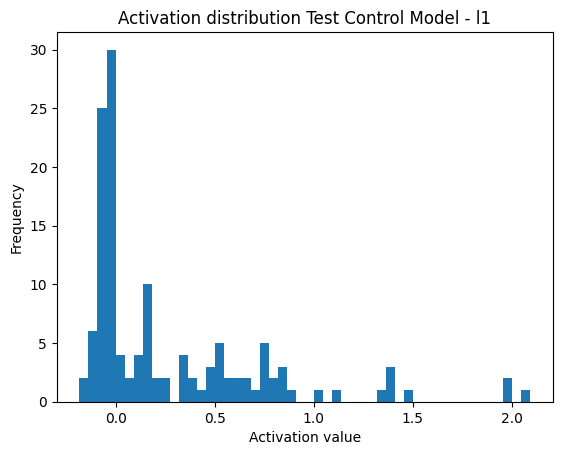

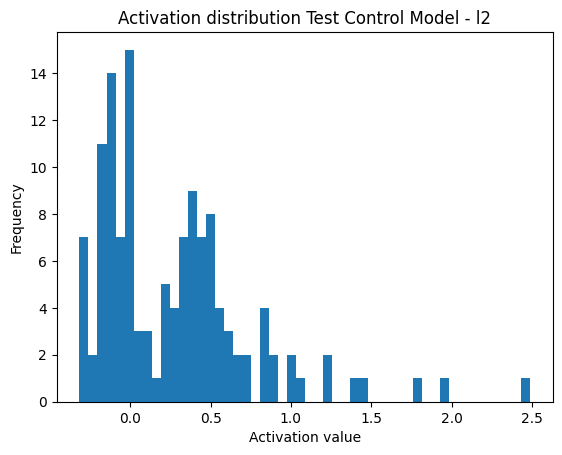

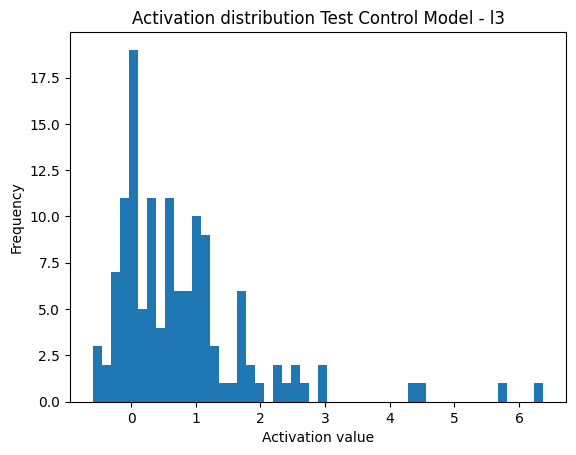

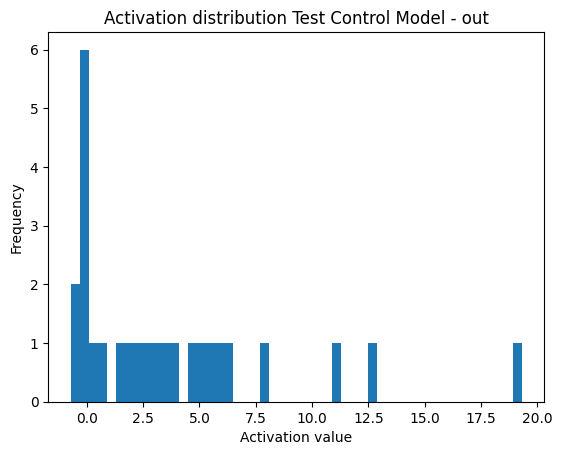

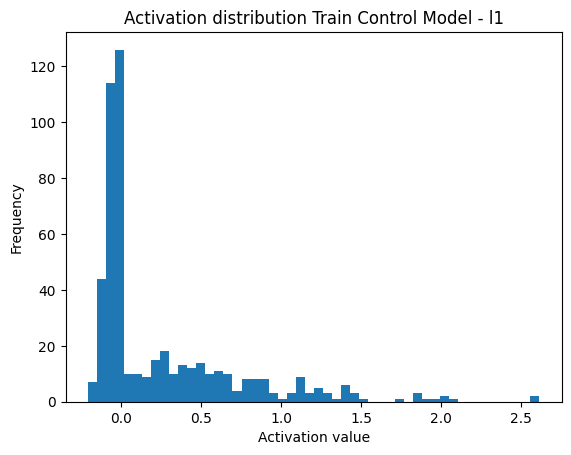

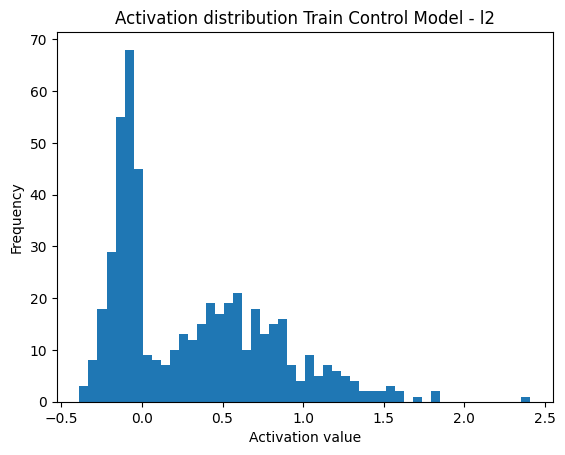

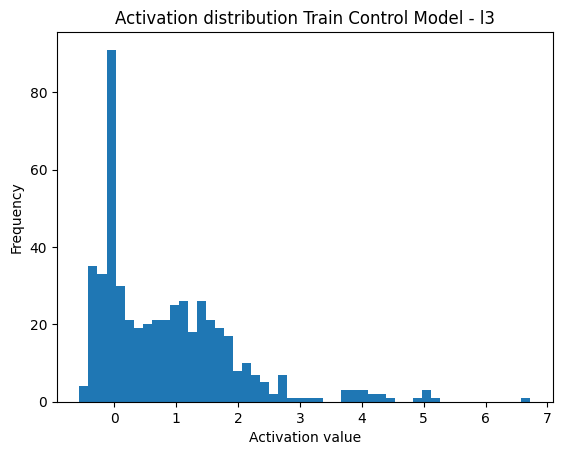

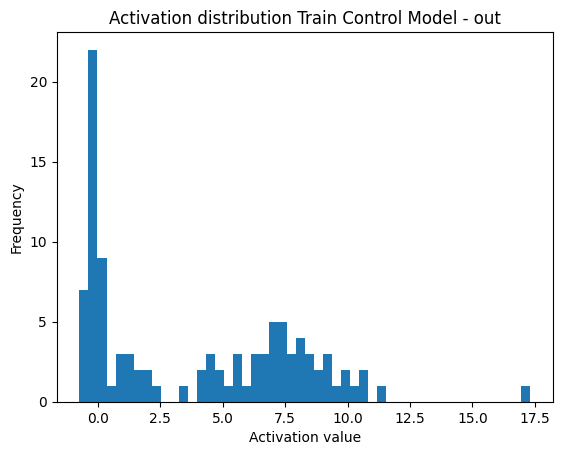

In [149]:
import numpy as np


run_number = 0
epoch_number = 149
layer_acts = {}
threshold = 1e-4
modelName = 'Control Model'

for layerName, layerAnalysis in multi_run_analysis.models[modelName].test_analysis.items():
    acts = layerAnalysis.activation_values[run_number]
    flat = acts.flatten()
    # filtered_flat = flat[np.abs(flat) > threshold]
    plt.hist(flat, bins=50)
    plt.title(f'Activation distribution Test {modelName} - {layerName}')
    plt.xlabel('Activation value')
    plt.ylabel('Frequency')
    plt.show()

for layerName, layerAnalysis in multi_run_analysis.models[modelName].train_analysis[epoch_number].layers.items():
    acts = layerAnalysis.activation_values[run_number]
    flat = acts.flatten()
    # filtered_flat = flat[np.abs(flat) > threshold]
    plt.hist(flat, bins=50)
    plt.title(f'Activation distribution Train {modelName} - {layerName}')
    plt.xlabel('Activation value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
n_runs = 1
model_analysis = []
for _ in range(n_runs):
    sparseResults, trainActivations, testActivations = get_models(experiment, 
                                                                  model_types, 
                                                                #   needTrainActivations = True, 
                                                                  batch_train = True)
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[model] = model.forward(X_val, return_acts = True)
            predicted = torch.argmax(op, 1)
            mismatched_indices = (predicted != y_val).nonzero(as_tuple=True)[0]
            test_acc = (predicted == y_val).float().mean().item()
            inv_acc = ((1 - predicted) == y_val).float().mean()

            mismatched_mask = (predicted != y_val)
            mismatched_indices = mismatched_mask.nonzero(as_tuple=True)[0]

            wrong_class0_idx = mismatched_indices[y_val[mismatched_indices] == 0]
            wrong_class1_idx = mismatched_indices[y_val[mismatched_indices] == 1]

            accuracy = get_accuracy(model, X_train, y_train)

            mean_out = op.mean(dim=0)
            std_out = op.std(dim=0)
            if accuracy != 1.:
                print(modelName, accuracy)
            model_analysis.append({
                "modelName": modelName,
                "train_acc": accuracy,
                "test_acc": test_acc,
                "inv_test_acc": inv_acc,
                "mean_op": mean_out,
                "std_out": std_out,
                "wrong_class_0": wrong_class0_idx,
                "wrong_class_1": wrong_class1_idx
            })

Control Model 0.9509803652763367
Complete Sparse model 0.9754902124404907
1st and 2nd L Sparse 0.9950980544090271
1st and 3rd L Sparse 0.9901960492134094


In [98]:
for item in model_analysis:
    print(f"\nModel: {item["modelName"]}")
    print(f"  Train Accuracy: {item["train_acc"]:.3f}")
    print(f"  Test Accuracy: {item["test_acc"]:.3f}")
    print(f"  Inverted test accuracy: {item["inv_test_acc"]:.3f}")
    print(f"  Output mean: {item["mean_op"].tolist()}")
    print(f"  Output std:  {item["std_out"].tolist()}")
    print(f"  Wrong Class 0:  {X_val[item["wrong_class_0"]].tolist()}")
    print(f"  Wrong Class 1:  {X_val[item["wrong_class_1"]].tolist()}")
    if item["std_out"].max() < 1e-4:
        print("  ⚠️ Dead output: very low activation variance for.")
    elif item["inv_test_acc"] > 0.5:
        print("  ⚠️ Systematic inversion (consistently wrong class).")
    elif abs(item["test_acc"] - 0.5) < 0.05:
        print("  🤷 Random guessing (around chance).")
    elif item["test_acc"] > 0.5:
        print("  ✅ Working normally.")
    else:
        print("  ❌ Below chance and not inverted — possibly degenerate outputs.")


Model: Control Model
  Train Accuracy: 0.951
  Test Accuracy: 0.481
  Inverted test accuracy: 0.519
  Output mean: [3.4267795085906982, 2.306713581085205]
  Output std:  [5.3249125480651855, 1.8707698583602905]
  Wrong Class 0:  [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]]
  Wrong Class 1:  [[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 

In [30]:
chartUtils_6D = {}
chartUtils_6D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=150,
    n_runs = 50,
    batch_train= True
)

for modelName in model_types:
    chartUtils_6D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 150,
        n_runs = 50,
        batch_train= True
        )

In [45]:
model_keys = list(chartUtils_6D.keys())
combined_charts: ChartUtil = chartUtils_6D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_6D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

In [46]:
import scipy.stats as st

model_to_90_acc = {}
model_to_95_acc = {}
results = {}
thresholds = [90., 95.]
for model, model_data in combined_charts.results.train_data.items():
    num_runs = 50
    
    epochs_to_threshold = {thr: [] for thr in thresholds}
    
    for run_idx in range(num_runs):
        # extract the accuracy curve for this run
        epochs = model_data.get_epoch_numbers()
        acc_curve = [model_data.epochs[epoch].train_acc[run_idx] for epoch in epochs]
        # print(acc_curve)
        for thr in thresholds:
            # find first epoch reaching threshold
            reached = [ep for ep, acc in zip(epochs, acc_curve) if acc >= thr]
            # print(reached)
            if reached:
                epochs_to_threshold[thr].append(reached[0])
    
    # store the results
    results[model] = epochs_to_threshold

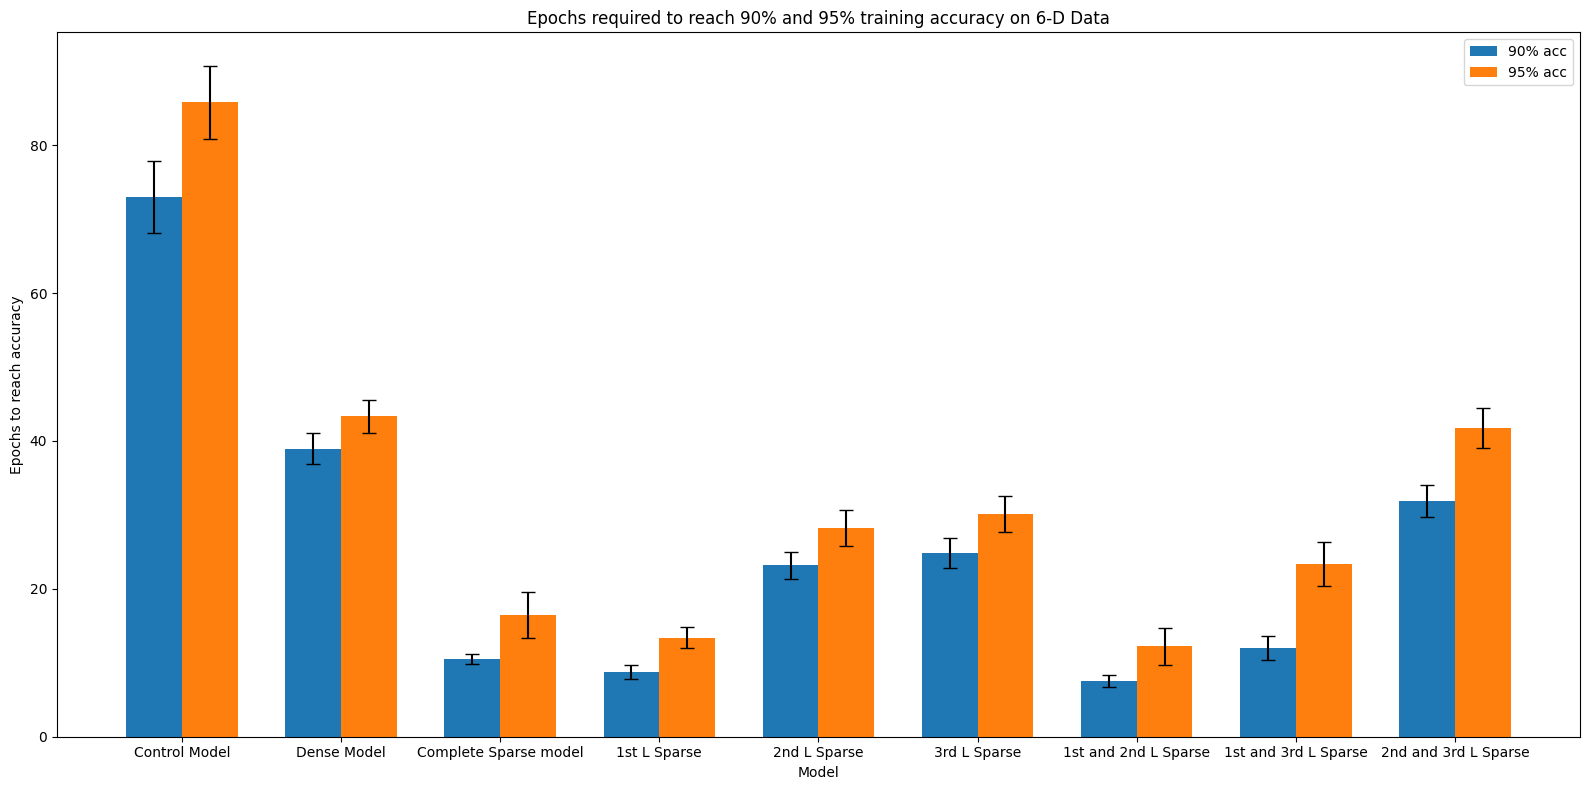

In [ ]:
summary = []
for model, data in results.items():
    for thr, epochs_list in data.items():
        if len(epochs_list) > 1:
            mean_epoch = np.mean(epochs_list)
            # ci_low, ci_high = st.t.interval(
            #     0.95, len(epochs_list)-1, loc=mean_epoch, scale=st.sem(epochs_list)
            # )
            sem = st.sem(epochs_list)
            ci = 1.96 * sem
            summary.append({
                "model": model,
                "threshold": thr,
                "mean_epoch": mean_epoch,
                "ci": ci
            })
df = pd.DataFrame(summary)

fig, ax = plt.subplots(figsize=(16, 8))

thresholds = sorted(df["threshold"].unique())
x = np.arange(len(df["model"].unique()))
width = 0.35

for i, thr in enumerate(thresholds):
    subset = df[df["threshold"] == thr]
    ax.bar(
        x + i*width,
        subset["mean_epoch"],
        width,
        yerr=subset["ci"],
        capsize=5,
        label=f"{int(thr)}% acc",
    )

ax.set_xticks(x + width / 2)
ax.set_xticklabels(df["model"].unique())
ax.set_ylabel("Epochs to reach accuracy")
ax.set_xlabel("Model")
ax.set_title("Epochs required to reach 90% and 95% training accuracy on 6-D Data")
ax.legend()
plt.tight_layout()
plt.show()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_27721/3681050318.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_27721/3681050318.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_27721/3681050318.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_27721/3681050318.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


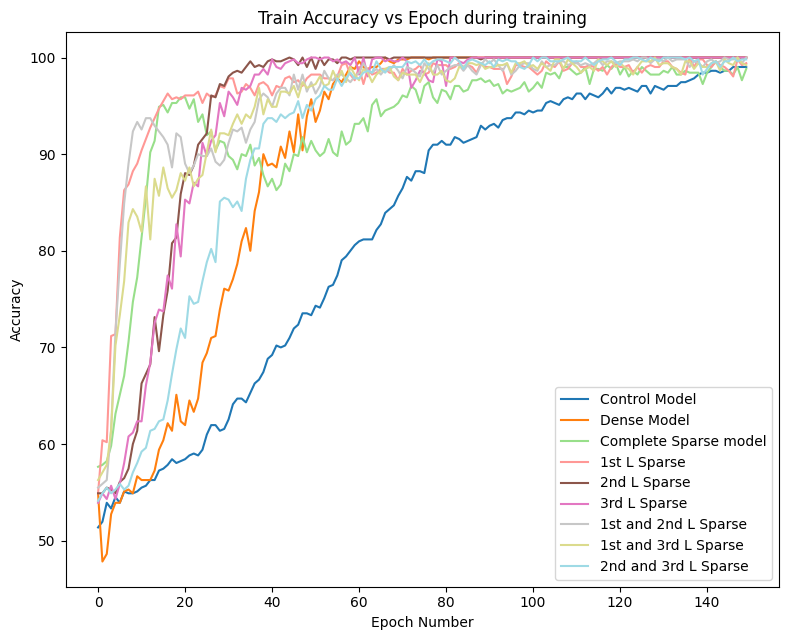

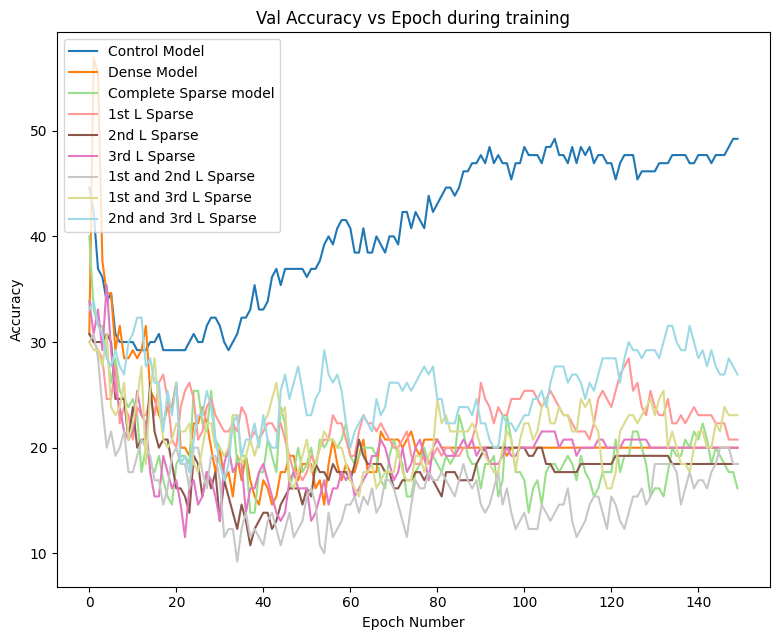

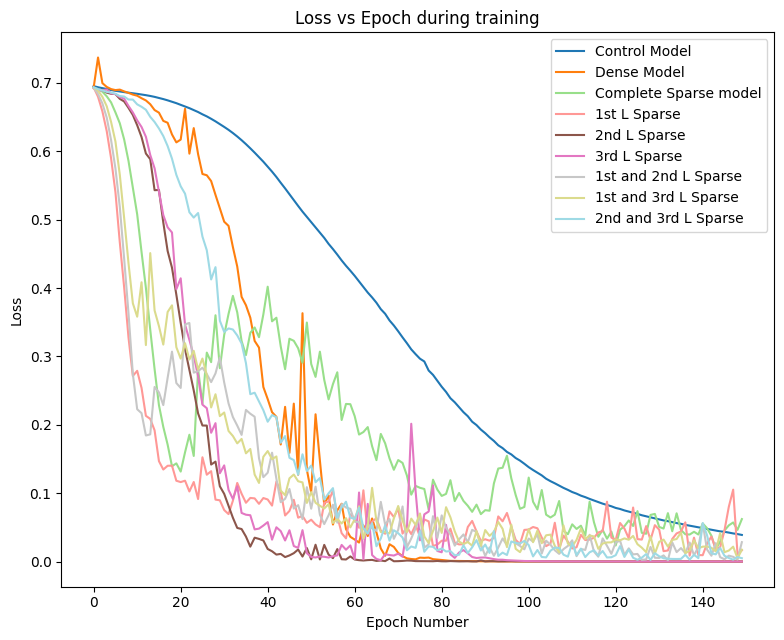

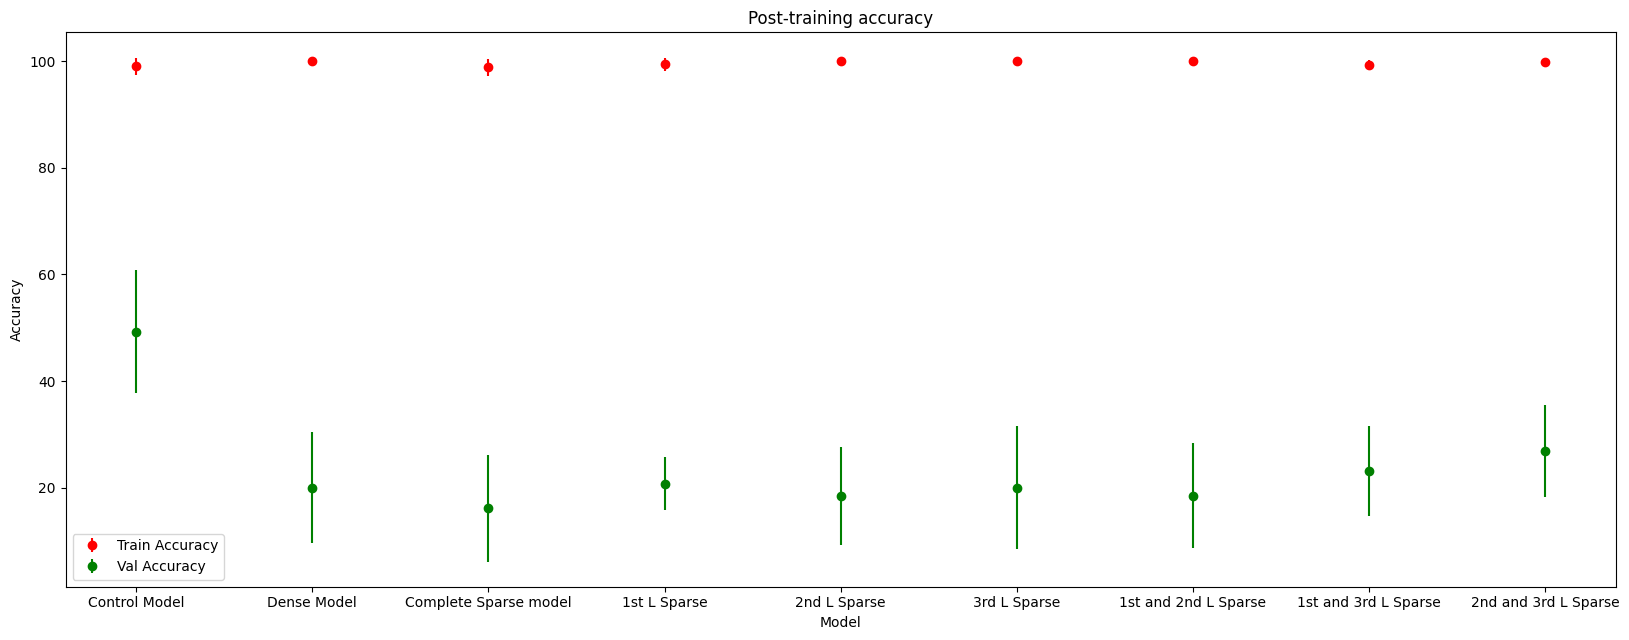

In [ ]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    # models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    # models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    no_std = True,
    # models = sparse_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    # models = sparse_models   
    ).show()

In [36]:
dataset = XOR()
in_features = 8
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [37]:
validate_input(X_train, X_val)
len(X_train), len(X_val)

[ 1.  4. 24. 49. 56. 43. 19.  7.  1.  0.  0.]
[ 0.  4.  4.  7. 14. 13.  9.  1.  0.  0.  0.]


(204, 52)

In [38]:
chartUtils_8D = {}
chartUtils_8D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs = 150,
    n_runs=50,
    batch_train= True
)

for modelName in model_types:
    chartUtils_8D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 150,
        n_runs = 50,
        batch_train= True
        )

In [49]:
model_keys = list(chartUtils_8D.keys())
combined_charts: ChartUtil = chartUtils_8D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_8D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

In [51]:
import scipy.stats as st

model_to_90_acc = {}
model_to_95_acc = {}
results = {}
thresholds = [90., 95.]
for model, model_data in combined_charts.results.train_data.items():
    num_runs = 50
    
    epochs_to_threshold = {thr: [] for thr in thresholds}
    
    for run_idx in range(num_runs):
        # extract the accuracy curve for this run
        epochs = model_data.get_epoch_numbers()
        acc_curve = [model_data.epochs[epoch].train_acc[run_idx] for epoch in epochs]
        # print(acc_curve)
        for thr in thresholds:
            # find first epoch reaching threshold
            reached = [ep for ep, acc in zip(epochs, acc_curve) if acc >= thr]
            # print(reached)
            if reached:
                epochs_to_threshold[thr].append(reached[0])
    
    # store the results
    results[model] = epochs_to_threshold

for model, data in results.items():
    print(f"\nModel: {model}")
    for thr, epochs_list in data.items():
        if len(epochs_list) > 1:
            mean_epoch = np.mean(epochs_list)
            sem = st.sem(epochs_list)
            ci = 1.96 * sem
            ci_low, ci_high = st.t.interval(
                0.95, len(epochs_list)-1, loc=mean_epoch, scale=st.sem(epochs_list)
            )
            print(f"  {int(thr)}% acc: mean={mean_epoch:.2f}, 95% CI=({ci_low:.2f}, {ci_high:.2f})")
            print(f"  {int(thr)}% acc: mean={mean_epoch:.2f}, 95% CI=({mean_epoch - ci:.2f}, {mean_epoch + ci:.2f})")
        elif len(epochs_list) == 1:
            print(f"  {int(thr)}% acc: mean={epochs_list[0]} (only one run)")
        else:
            print(f"  {int(thr)}% acc: not reached")


Model: Control Model
  90% acc: mean=105.68, 95% CI=(98.56, 112.79)
  90% acc: mean=105.68, 95% CI=(98.85, 112.51)
  95% acc: mean=123.65, 95% CI=(116.33, 130.97)
  95% acc: mean=123.65, 95% CI=(116.69, 130.62)

Model: Dense Model
  90% acc: mean=55.02, 95% CI=(51.91, 58.13)
  90% acc: mean=55.02, 95% CI=(51.98, 58.06)
  95% acc: mean=60.32, 95% CI=(57.24, 63.40)
  95% acc: mean=60.32, 95% CI=(57.32, 63.32)

Model: Complete Sparse model
  90% acc: mean=53.16, 95% CI=(45.46, 60.86)
  90% acc: mean=53.16, 95% CI=(45.65, 60.67)
  95% acc: mean=95.38, 95% CI=(90.41, 100.35)
  95% acc: mean=95.38, 95% CI=(90.53, 100.23)

Model: 1st L Sparse
  90% acc: mean=26.44, 95% CI=(23.66, 29.22)
  90% acc: mean=26.44, 95% CI=(23.73, 29.15)
  95% acc: mean=36.96, 95% CI=(32.98, 40.94)
  95% acc: mean=36.96, 95% CI=(33.08, 40.84)

Model: 2nd L Sparse
  90% acc: mean=45.04, 95% CI=(42.58, 47.50)
  90% acc: mean=45.04, 95% CI=(42.64, 47.44)
  95% acc: mean=50.90, 95% CI=(48.14, 53.66)
  95% acc: mean=50.

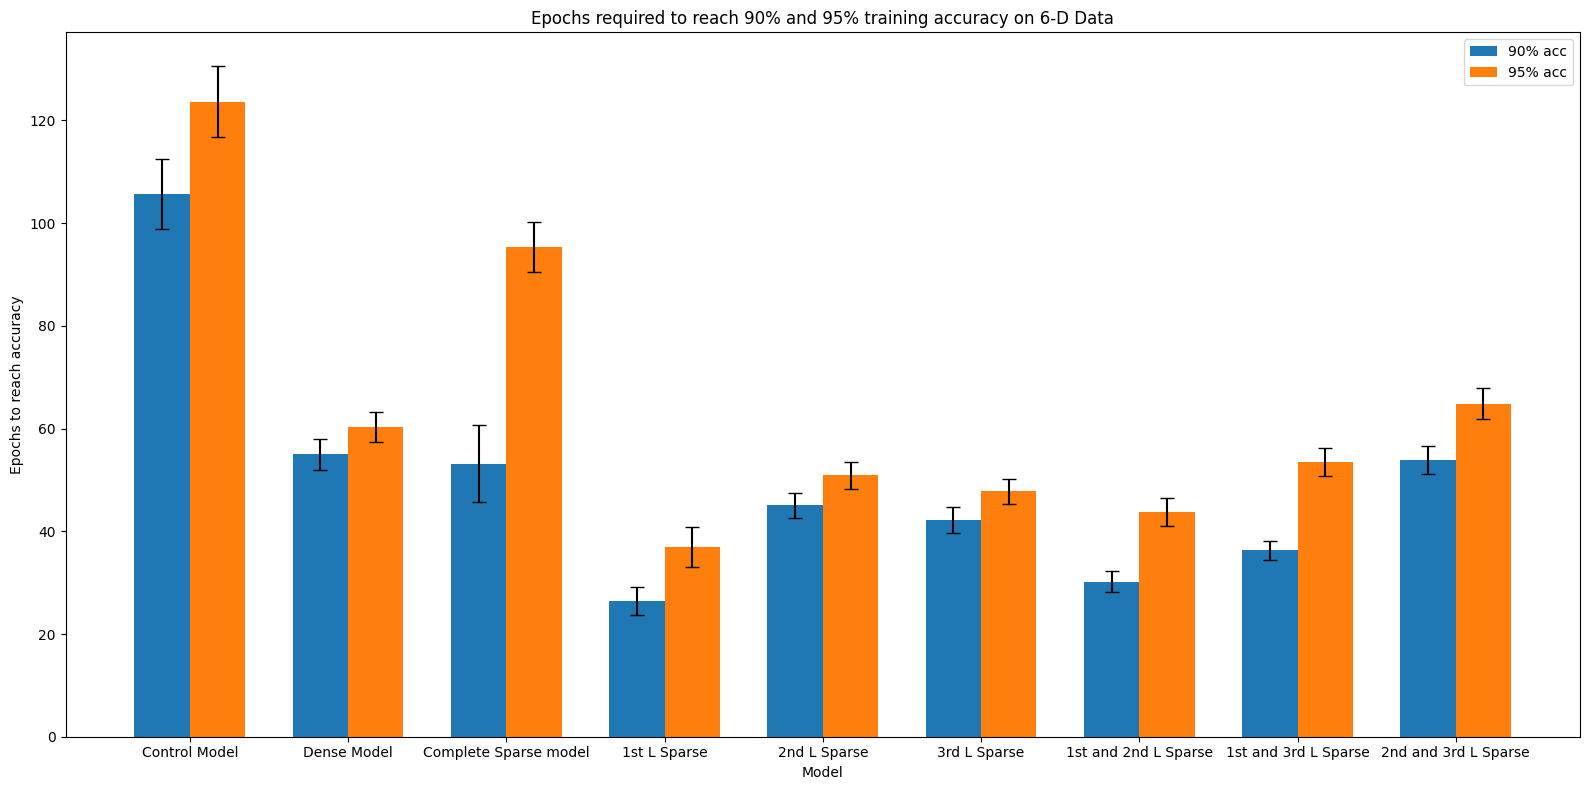

In [52]:
summary = []
for model, data in results.items():
    for thr, epochs_list in data.items():
        if len(epochs_list) > 1:
            mean_epoch = np.mean(epochs_list)
            # ci_low, ci_high = st.t.interval(
            #     0.95, len(epochs_list)-1, loc=mean_epoch, scale=st.sem(epochs_list)
            # )
            sem = st.sem(epochs_list)
            ci = 1.96 * sem
            summary.append({
                "model": model,
                "threshold": thr,
                "mean_epoch": mean_epoch,
                "ci": ci
            })
df = pd.DataFrame(summary)

fig, ax = plt.subplots(figsize=(16, 8))

thresholds = sorted(df["threshold"].unique())
x = np.arange(len(df["model"].unique()))
width = 0.35

for i, thr in enumerate(thresholds):
    subset = df[df["threshold"] == thr]
    ax.bar(
        x + i*width,
        subset["mean_epoch"],
        width,
        yerr=subset["ci"],
        capsize=5,
        label=f"{int(thr)}% acc",
    )

ax.set_xticks(x + width / 2)
ax.set_xticklabels(df["model"].unique())
ax.set_ylabel("Epochs to reach accuracy")
ax.set_xlabel("Model")
ax.set_title("Epochs required to reach 90% and 95% training accuracy on 6-D Data")
ax.legend()
plt.tight_layout()
plt.show()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_25822/3690377020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_25822/3690377020.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_25822/3690377020.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_25822/3690377020.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


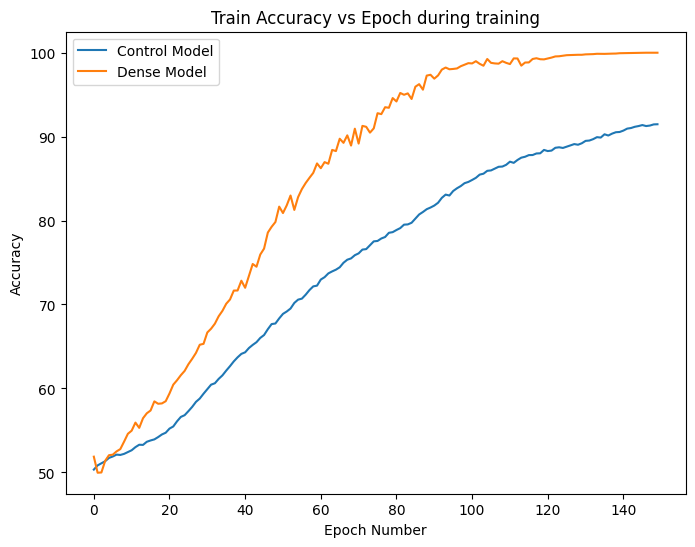

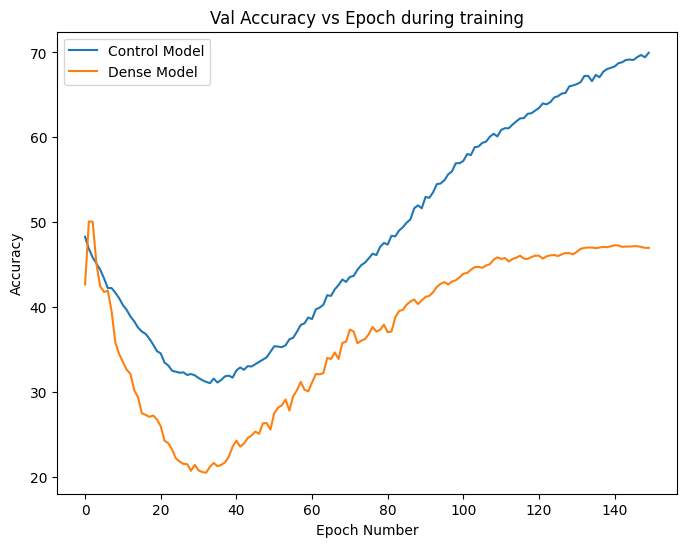

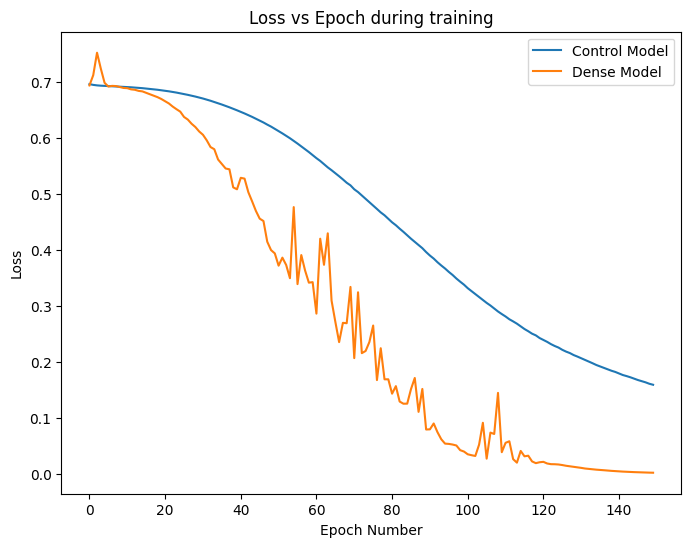

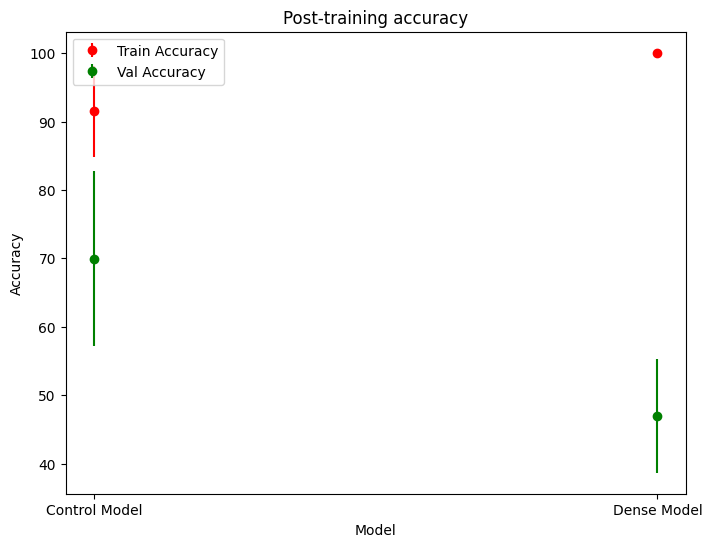

In [59]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    models = control_models + dense_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    models = control_models + dense_models   
    ).show()
combined_charts.plot_training_data_for(
    no_std = True,
    models = control_models + dense_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    models = control_models + dense_models   
    ).show()

In [13]:
dataset = XOR()
in_features = 10
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)
validate_input(X_train, X_val)

[  1.   8.  35.  97. 178. 204. 162.  91.  33.   9.   1.]
[ 0.  2. 10. 23. 32. 48. 48. 29. 12.  1.  0.]


In [14]:
chartUtils_10D = {}
chartUtils_10D["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=400,
    batch_train= True,
    n_runs = 20
)

for modelName in model_types:
    print("Starting", modelName)
    chartUtils_10D[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 400,
        batch_train= True,
        n_runs = 20
        )
    print("Ending", modelName)

Starting Complete Sparse model
Ending Complete Sparse model
Starting 1st L Sparse
Ending 1st L Sparse
Starting 2nd L Sparse
Ending 2nd L Sparse
Starting 3rd L Sparse
Ending 3rd L Sparse
Starting 1st and 2nd L Sparse
Ending 1st and 2nd L Sparse
Starting 1st and 3rd L Sparse
Ending 1st and 3rd L Sparse
Starting 2nd and 3rd L Sparse
Ending 2nd and 3rd L Sparse


In [15]:
model_keys = list(chartUtils_10D.keys())
combined_charts: ChartUtil = chartUtils_10D[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_10D[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_9555/3521643863.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


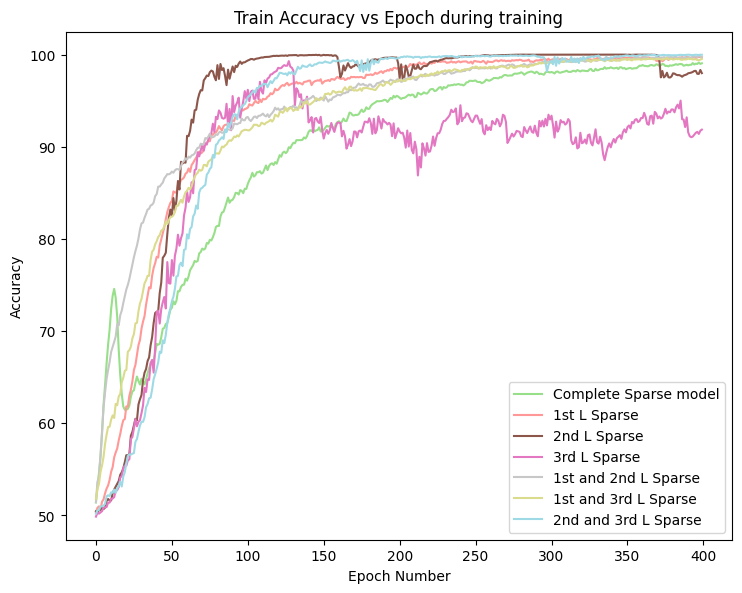

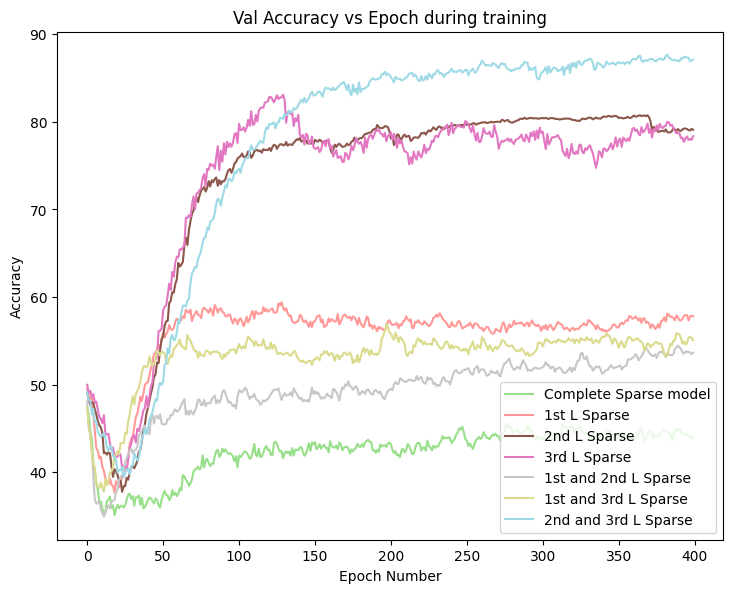

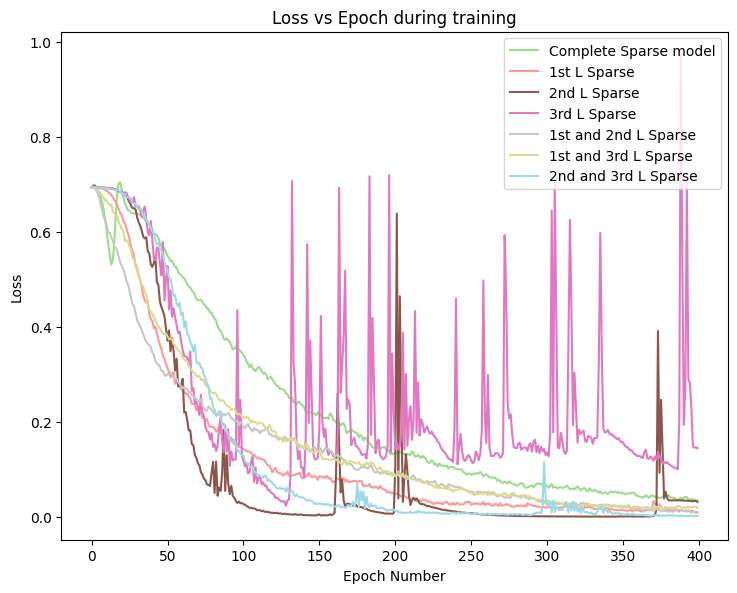

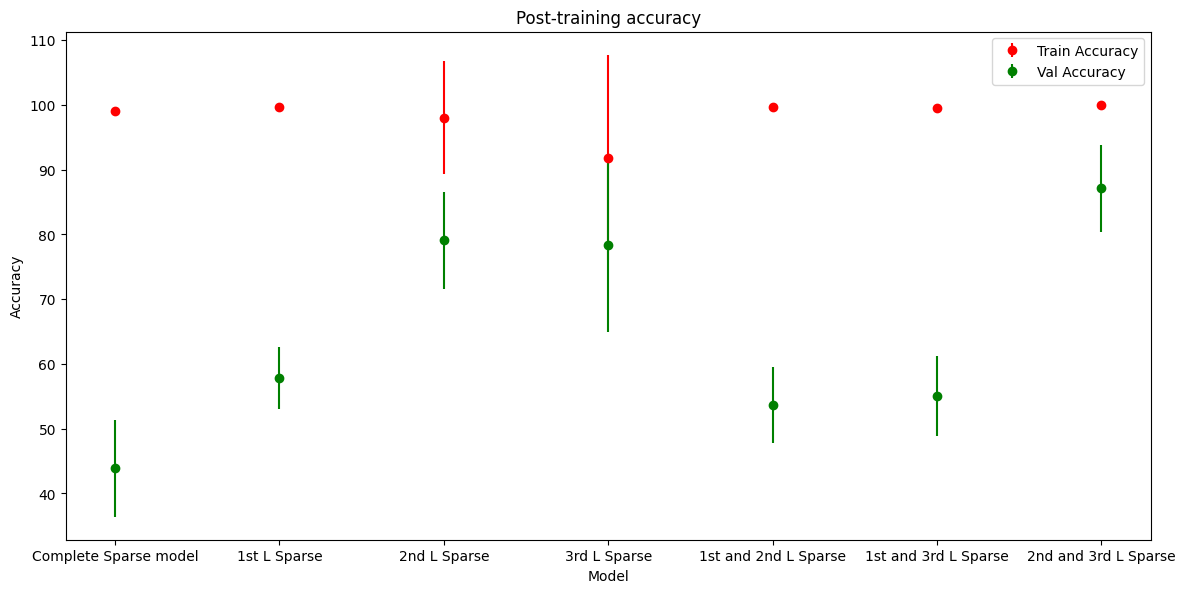

In [18]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(no_std = True,
                                      models = sparse_models
                                       ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    models = sparse_models
    ).show()

In [67]:
from datasets.dymmyProblem import DummyDataset


dataset = DummyDataset()
X_train, y_train, X_val, y_val = dataset.get_dataset(original_split= True, unique = True)
in_features = len(X_train[0])
out_features = 2
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [68]:
len(X_train), len(X_val)

(14, 12)

In [69]:
chartUtils_7D_dummy = {}
chartUtils_7D_dummy["all"] = experiment.perform_one_experiment(
    models = 
    {
        "Control Model": modelSetups._get_control_model,
        "Dense Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = layers,  
    model_params = model_types["Complete Sparse model"],
    n_epochs=250,
    # batch_train= True,
    n_runs = 50,
    lr=0.005
)

for modelName in model_types:
    print("Starting", modelName)
    chartUtils_7D_dummy[modelName] = experiment.perform_one_experiment(
        models = {
            modelName: modelSetups._get_sparse_model,
            },
        in_features = in_features, 
        out_features = out_features, 
        layers = layers, 
        model_params = model_types[modelName],
        n_epochs = 250,
        # batch_train= True,
        n_runs = 50,
        lr=0.005
        )
    print("Ending", modelName)

Starting Complete Sparse model
Ending Complete Sparse model
Starting 1st L Sparse
Ending 1st L Sparse
Starting 2nd L Sparse
Ending 2nd L Sparse
Starting 3rd L Sparse
Ending 3rd L Sparse
Starting 1st and 2nd L Sparse
Ending 1st and 2nd L Sparse
Starting 1st and 3rd L Sparse
Ending 1st and 3rd L Sparse
Starting 2nd and 3rd L Sparse
Ending 2nd and 3rd L Sparse


In [70]:
model_keys = list(chartUtils_7D_dummy.keys())
combined_charts: ChartUtil = chartUtils_7D_dummy[model_keys[0]]

for key in model_keys[1:]:
    combined_charts = combined_charts.combine_charts(chartUtils_7D_dummy[key])

sparse_models, control_models, dense_models = get_models_to_plot_from_combined(combined_charts)
combined_charts.set_colors_map()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_6350/807361623.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_6350/807361623.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_6350/807361623.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_6350/807361623.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_6350/807361623.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


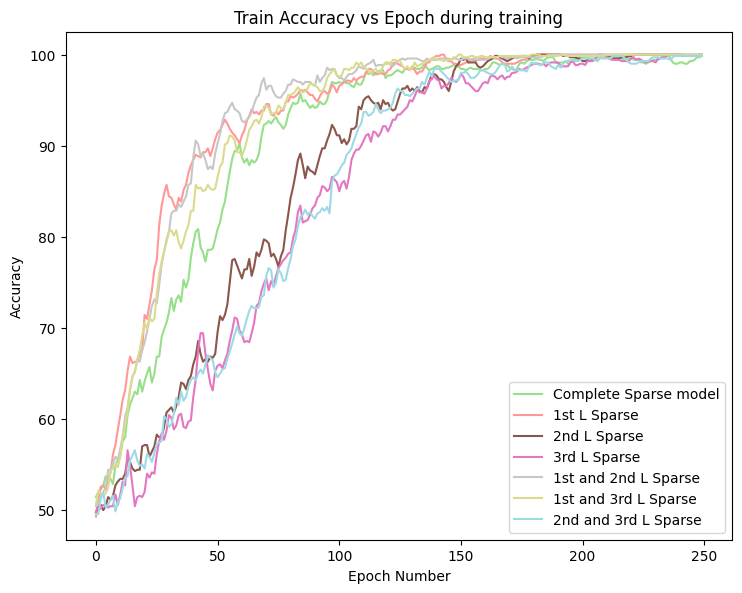

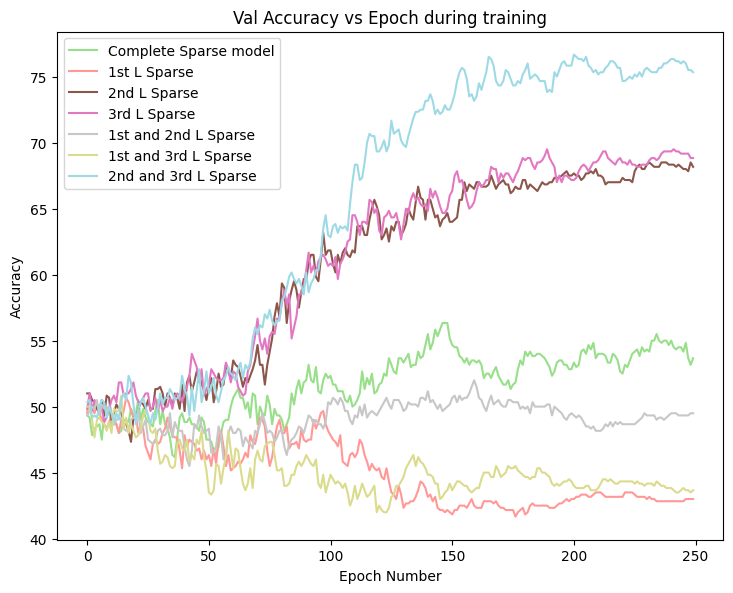

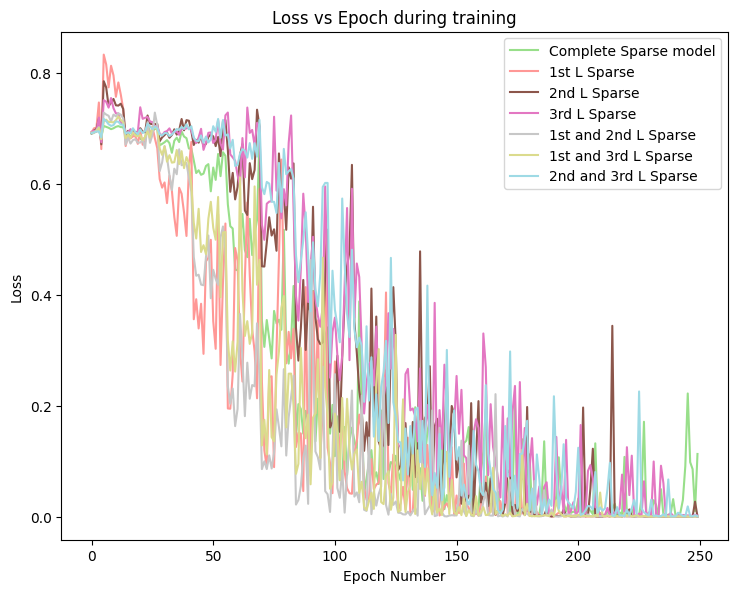

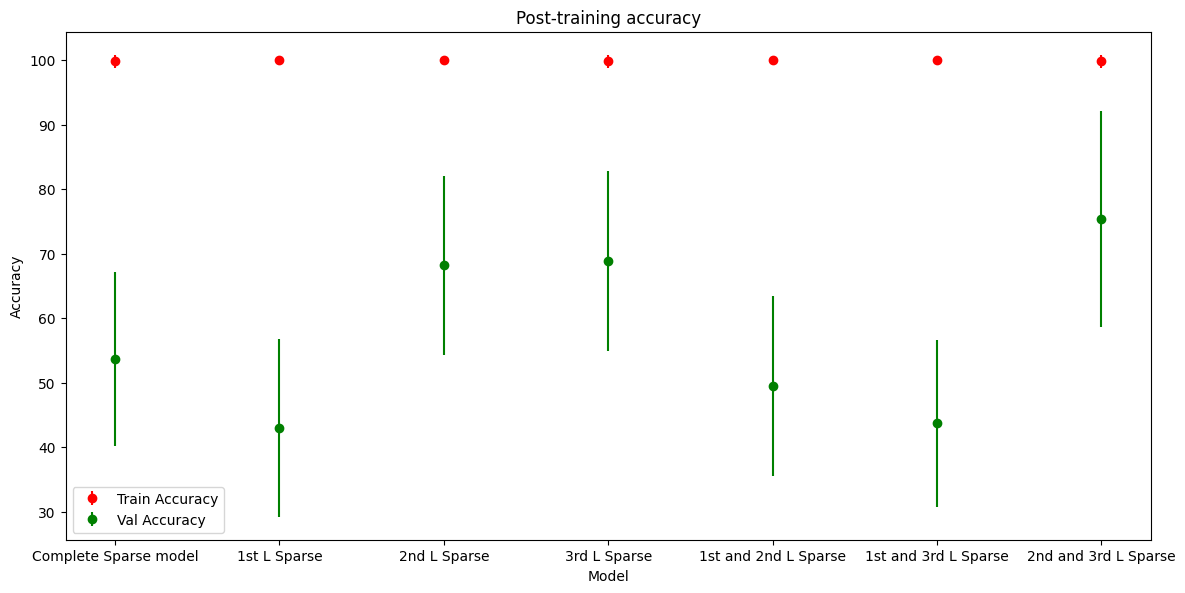

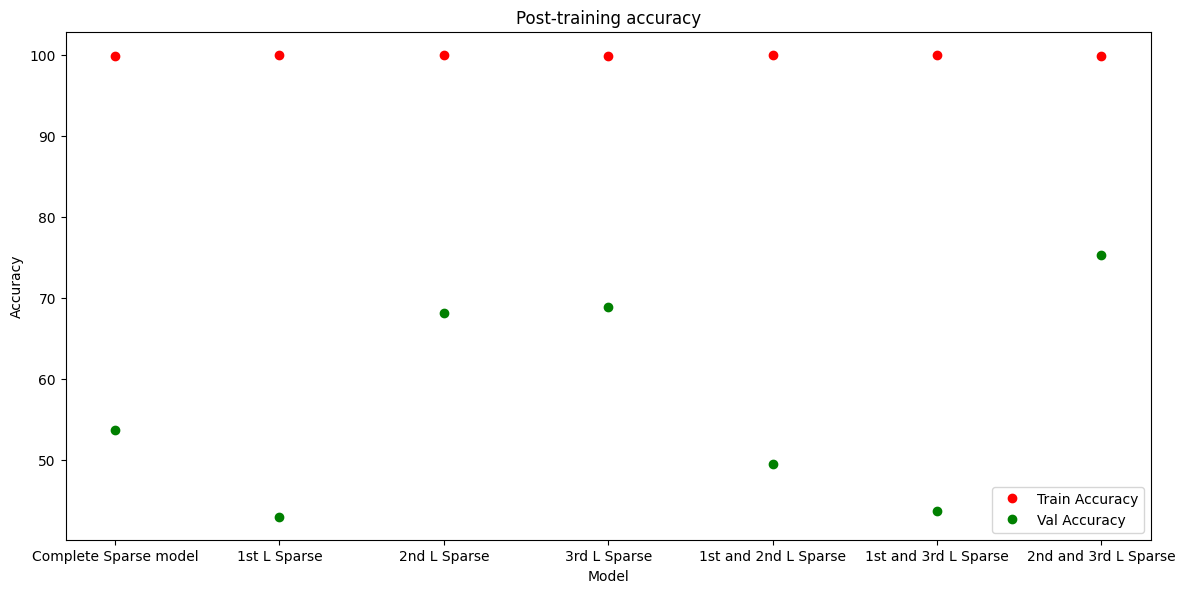

In [73]:
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.TRAIN_ACC, 
    no_std = True,
    models = sparse_models   
    ).show()
combined_charts.plot_training_data_for(
    value_to_plot = TrainingCharts.VAL_ACC, 
    no_std = True,
    models = sparse_models    
    ).show()
combined_charts.plot_training_data_for(
    no_std = True,
    models = sparse_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    models = sparse_models 
    ).show()
combined_charts.plot_test_accu_for_models(
    width_alpha=3,
    no_std= True,
    models = sparse_models
    ).show()